In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import copy
from sklearn.model_selection import train_test_split

# for import data
import torchvision
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
cdata = torchvision.datasets.EMNIST(root = 'emnist', split = 'letters', download = True)


100%|██████████| 561753746/561753746 [00:05<00:00, 100653031.70it/s]


Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


In [4]:
print(cdata.classes)
print(str(len(cdata.classes)) + 'classes')

print('\nData Size')
print(cdata.data.shape)

images = cdata.data.view([124800, 1, 28, 28]).float()
print('\n Tensor data: ')
print(images.shape)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27classes

Data Size
torch.Size([124800, 28, 28])

 Tensor data: 
torch.Size([124800, 1, 28, 28])


In [5]:
# class 'N/A' doesnt exist in data
print(torch.sum(cdata.targets == 0))

torch.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [6]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [7]:
letterCategories = cdata.classes[1:]

labels = copy.deepcopy(cdata.targets) - 1
print(labels.shape)

print(torch.sum(labels == 0))
torch.unique(labels)
# labels = labels[:,None]

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

In [8]:
labels.shape

torch.Size([124800])

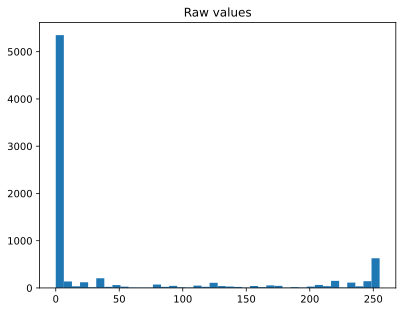

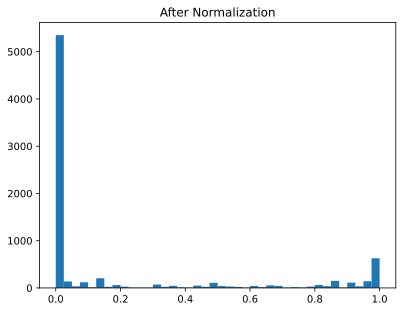

In [9]:
plt.hist(images[:10, :,:,:].view(1, -1).detach(), 40)
plt.title('Raw values')
plt.show()

# yarp
images /= torch.max(images)
plt.title('After Normalization')
plt.hist(images[:10, :,:,:].view(1, -1).detach(), 40)
plt.show()

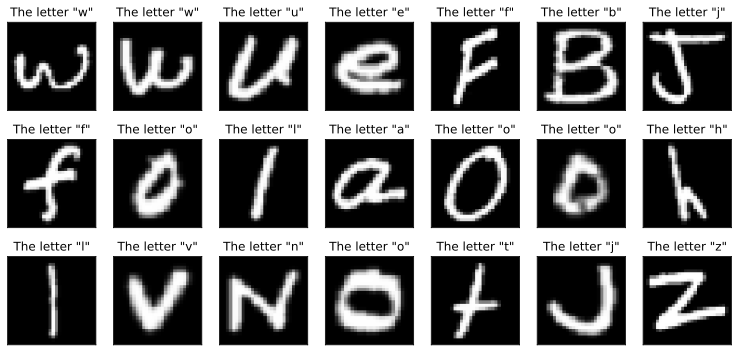

In [10]:
fig, axs = plt.subplots(3, 7, figsize = (13, 6))

for i, ax in enumerate(axs.flatten()):

    whichpic = np.random.randint(images.shape[0])

    I = np.squeeze(images[whichpic, :,:])
    letter = letterCategories[labels[whichpic]]

    # visualize
    ax.imshow(I.T, cmap = 'gray')
    ax.set_title('The letter "%s"'%letter)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [14]:
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size = 5000)
train_data1 = torch.zeros(train_data.shape)
test_data1 = torch.zeros(test_data.shape)

for i in range(len(train_data)):
    train_data1[i, 0,:,:] = train_data[i, 0,:,:].T
for i in range(len(test_data)):
    test_data1[i, 0,:,:] = test_data[i, 0,:,:].T
train_dataset = TensorDataset(train_data1, train_labels)
test_dataset = TensorDataset(test_data1, test_labels)

batchsize = 32
train_loader = DataLoader(train_dataset, batch_size = batchsize, shuffle = True )
test_loader = DataLoader(train_dataset, batch_size = test_dataset.tensors[0].shape[0])

In [20]:
def makeTheNet(printtoggle = False):

    class emnist(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            # Print toggle
            self.print = printtoggle

            ### ------------ feature map layers --------------- ###

            # first convolution error
            self.conv1 = nn.Conv2d(1, 3, 5, padding = 2)
            self.conv2 = nn.Conv2d(3, 6, 3, padding = 1)
            self.bnorm1 = nn.BatchNorm2d(6)
            # output size: (28 + 2*1 - 3)/1 + 2 = 28 /2 # max pool = 14

            self.conv3 = nn.Conv2d(6, 12, 3, padding = 1)
            self.conv4 = nn.Conv2d(12, 24, 3, padding = 1)
            self.bnorm2 = nn.BatchNorm2d(24)
            # output size: (14 + 2*1 - 3)/1 + 2 = 14 /2 # Pooling = 7

            ### ------------ Linear decision layers --------------###
            self.fc1 = nn.Linear(7*7*24, 256)
            self.fc2 = nn.Linear(256, 128)
            self.fc3 = nn.Linear(128, 26)

        def forward(self, x):
            if self.print: print(f'Input: {list(x.shape)}')

            # first block
            x = F.max_pool2d(self.conv2(self.conv1(x)),2)
            x = F.leaky_relu(self.bnorm1(x))

            if self.print: print(f'First CPR block: {list(x.shape)}')

            x = F.max_pool2d(self.conv4(self.conv3(x)), 2)
            x = F.leaky_relu(self.bnorm2(x))

            if self.print: print(f'First CPR block: {list(x.shape)}')

            # reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')

            # linear layers
            x = F.relu(self.fc1(x))
            x = F.dropout(x, p = .5, training = self.training)
            x = F.relu(self.fc2(x))
            x = F.dropout(x, p = .5, training = self.training)
            x = self.fc3(x)

            if self.print: print(f'Final output: {list(x.shape)}')
            return x
    net = emnist(printtoggle)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr = .001)

    return net, lossfun, optimizer






In [30]:
net, lossfun, optimzier = makeTheNet(True)
X, y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# now lets compute the loss
loss = lossfun(yHat, torch.squeeze(y))
print(' ')
print('Loss')
print(loss)

Input: [32, 1, 28, 28]
First CPR block: [32, 6, 14, 14]
First CPR block: [32, 24, 7, 7]
Vectorized: [32, 1176]
Final output: [32, 26]

Output size:
torch.Size([32, 26])
 
Loss
tensor(3.2513, grad_fn=<NllLossBackward0>)


In [34]:
def function2trainTheModel():

    # number of epochs
    numepochs = 30

    # create a new model
    net, lossfun, optimizer = makeTheNet()

    # send the model to the GPu
    net.to(device)

    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    trainErr = torch.zeros(numepochs)
    testErr = torch.zeros(numepochs)

    for epochi in range(numepochs):

        # loop over training data batches
        net.train()
        batchLoss = []
        batchErr = []

        for X, y in train_loader:

            X = X.to(device)
            y = y.to(device)
            yHat = net(X)
            loss = lossfun(yHat, y)
            batchLoss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchErr.append(torch.mean((torch.argmax(yHat.cpu(), axis = 1) != y.cpu()).float()).item())

        trainLoss[epochi] = np.mean(batchLoss)
        trainErr[epochi] = 100*np.mean(batchErr)

        # test performance
        net.eval()
        X, y = next(iter(test_loader))
        X = X.to(device)
        y = y.to(device)

        with torch.inference_mode():
            yHat = net(X)
            loss = lossfun(yHat, y)
            testLoss[epochi] = loss.item()
            testErr[epochi] = 100*(torch.mean((torch.argmax(yHat.cpu(), axis = 1) != y.cpu()).float()).item())

    return trainLoss, testLoss, trainErr, testErr, net






In [35]:
trainLoss, testLoss, trainErr, testErr, net = function2trainTheModel()

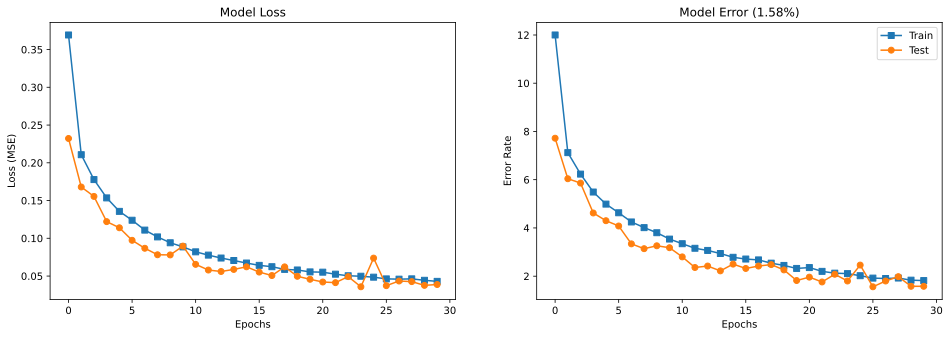

In [36]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(trainLoss, 's-', label = 'Train')
ax[0].plot(testLoss, 'o-', label = 'Test')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Model Loss')


ax[1].plot(trainErr, 's-', label = 'Train')
ax[1].plot(testErr, 'o-', label = 'Test')
ax[1].set_ylabel('Error Rate')
ax[1].set_xlabel('Epochs')
ax[1].set_title(f'Model Error ({testErr[-1]:.2f}%)')

plt.legend()
plt.show()

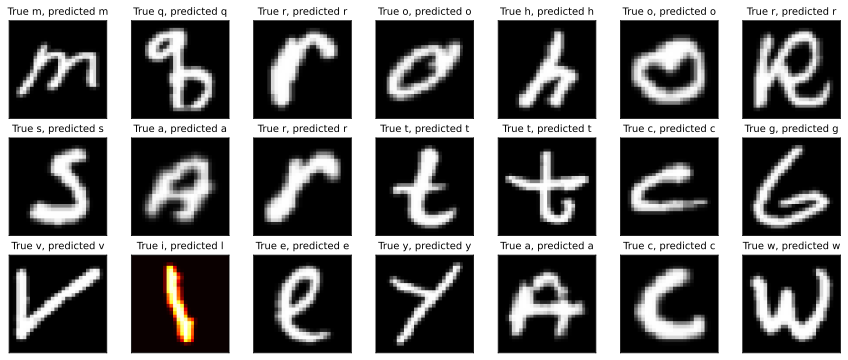

In [ ]:
### visualize some images

# extract X,y from test dataloader
X,y = next(iter(test_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU
yHat = net(X)

# pick some examples at random to show
randex = np.random.choice(len(y),size=21,replace=False)

# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[randex[i],0,:,:] ).cpu() # .cpu() to transfer back from GPU!
  trueLetter = letterCategories[ y[randex[i]] ]
  predLetter = letterCategories[ torch.argmax(yHat[randex[i],:]) ]

  # color-code the accuracy (using ternary operator)
  col = 'gray' if trueLetter==predLetter else 'hot'

  # visualize
  ax.imshow(I,cmap=col)
  ax.set_title('True %s, predicted %s' %(trueLetter,predLetter),fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

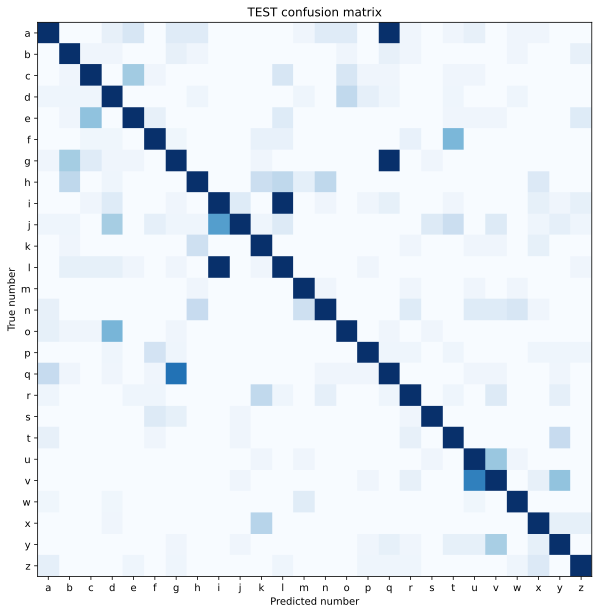

In [ ]:
import sklearn.metrics as skm

# compute the confusion matrix
C = skm.confusion_matrix(y.cpu(),torch.argmax(yHat.cpu(),axis=1),normalize='true')

# visualize it
fig = plt.figure(figsize=(10,10))
plt.imshow(C,'Blues',vmax=.05)

# make the plot look nicer
plt.xticks(range(26),labels=letterCategories)
plt.yticks(range(26),labels=letterCategories)
plt.title('TEST confusion matrix')
plt.xlabel('True number')
plt.xlabel('Predicted number')
plt.ylabel('True number')

plt.show()